In [1]:
import sys
sys.path.extend(['..'])

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import json
from pathlib import Path
from tqdm.auto import trange

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [3]:
demo_distribution, demo_lambdas = 'mix_laplace', ['1.01', '2.0', '8.0', '64.0']
stan_file = Path('..') / demo_distribution / (demo_distribution + '.stan')
data_file = Path('..') / demo_distribution / 'data.json'
isvi_csvs = [Path('..') / demo_distribution / f'isvi_{lam}_1.csv' for lam in demo_lambdas]

assert stan_file.exists()
assert data_file.exists()
for isvi in isvi_csvs:
    if not isvi.exists():
        print("Need to run", isvi)

In [4]:
%%capture
with open(stan_file, 'r') as f:
    if data_file.exists():
        with open(data_file, 'r') as d:
            data = json.load(d)
    else:
        data = None
    stan_model = stan.build(f.read(), data=data)

In [5]:
isvi_results = [pd.read_csv(isvi, comment='#') for isvi in isvi_csvs]

  0%|          | 0/200 [00:00<?, ?it/s]

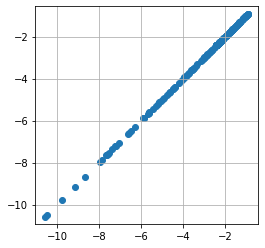

In [6]:
def log_prob_mix_laplace(x, means=(-1.5, 1.5), weights=(0.4, 0.6), scales=(0.75, 0.75)):
    means, weights, scales = torch.tensor(means), torch.tensor(weights), torch.tensor(scales)
    mode_log_probs = -torch.abs((x.view(-1, 1) - means.view(1, -1)) / scales.view(1, -1)) - torch.log(2 * scales)
    log_probs = torch.logsumexp(torch.log(weights.view(1, -1)) + mode_log_probs, dim=1)
    return log_probs.reshape(x.size())


test_x = np.random.randn(200)*3
my_lp = log_prob_mix_laplace(torch.tensor(test_x))
stan_lp = np.zeros(test_x.size)
for i in trange(test_x.size):
    stan_lp[i] = stan_model.log_prob([test_x[i]])

plt.figure(figsize=(4,4))
plt.scatter(stan_lp, my_lp)
plt.grid('on')
plt.axis('equal')
plt.show()

In [7]:
x = np.linspace(-5, 5, 500)
log_p = log_prob_mix_laplace(torch.tensor(x))
p = np.exp(log_p)

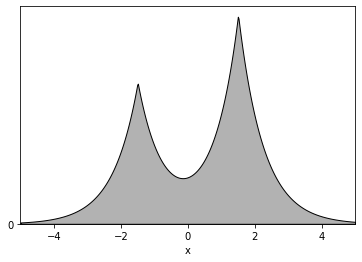

In [8]:
def draw_p(ax):
    ax.fill_between(x, p, np.zeros(x.shape), edgecolor=(0.,0.,0.,1.), facecolor=(0.,0.,0.,0.3), label='p(x)')
    ax.set_yticks([0])
    ax.set_xlabel('x')
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([0, None])
draw_p(plt.subplot(111))
plt.savefig('mix-laplace.pdf')

In [9]:
LOG2PI = np.log(2*np.pi)

def samples_to_limits(samples, clip_lo=float('-inf'), clip_hi=float('+inf')):
    lo_hi = np.array([max(clip_lo, samples.min()), min(clip_hi, samples.max())])
    midpoint = np.mean(lo_hi)
    return midpoint + 1.1 * (lo_hi - midpoint)

def compute_kl_qp(mus, omegas, n_kl_samples=100):
    eps = np.random.randn(n_kl_samples)
    mm, oo = np.meshgrid(mus, omegas)
    ss = np.exp(oo)
    kl = np.zeros(mm.size)
    for i in trange(mm.size, desc='KL(q||p)'):
        x_samples = mm.flatten()[i] + ss.flatten()[i]*eps
        qlogp = torch.mean(log_prob_mix_laplace(torch.tensor(x_samples))).item()
        ent_q = 0.5*(1+LOG2PI) + oo.flatten()[i]
        kl[i] = -ent_q - qlogp
    return np.reshape(kl, mm.shape)

def compute_log_det_fim(mus, omegas):
    mm, oo = np.meshgrid(mus, omegas)
    return -2 * oo

log_psi = []
for l, r in zip(demo_lambdas, isvi_results):
    m = np.linspace(-5, 5, 100)
    o = np.linspace(*samples_to_limits(r['omega_x'], clip_lo=np.log(1e-6)), 100)
    kl_qp = compute_kl_qp(m, o)
    fim = compute_log_det_fim(m, o)
    lp = 0.5*fim - float(l)*kl_qp
    log_psi.append({
        'lambda': float(l),
        'mu': m,
        'omega': o,
        'kl_qp': kl_qp,
        'log_det_fim': fim,
        'log_psi': lp,
        'psi': np.exp(lp - np.max(lp))
    })

KL(q||p):   0%|          | 0/10000 [00:00<?, ?it/s]

KL(q||p):   0%|          | 0/10000 [00:00<?, ?it/s]

KL(q||p):   0%|          | 0/10000 [00:00<?, ?it/s]

KL(q||p):   0%|          | 0/10000 [00:00<?, ?it/s]

Frames:   0%|          | 0/300 [00:00<?, ?it/s]

ValueError: unknown file extension: .mp4

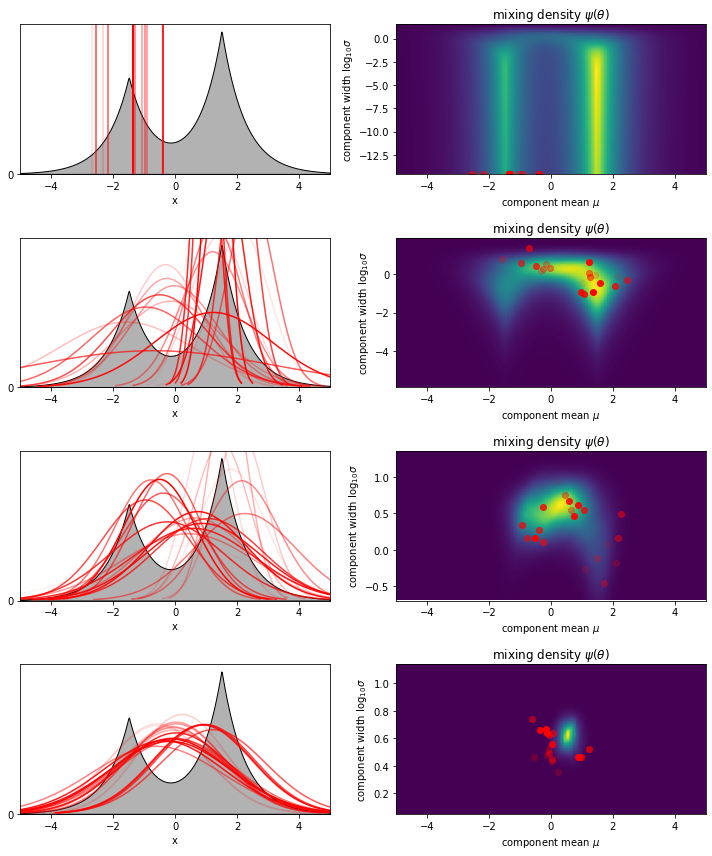

In [11]:
from matplotlib import animation
from scipy import stats

fig, ax = plt.subplots(len(demo_lambdas), 2, figsize=(10, 3*len(demo_lambdas)))

i_start = 500
n_components_plot = 20
n_frames = 300
component_handles = [[None]*n_components_plot for _ in range(len(demo_lambdas))]
dot_handles = [[None]*n_components_plot for _ in range(len(demo_lambdas))]

def init():
    for i, (r, lp) in enumerate(zip(isvi_results, log_psi)):
        # Backgrounds
        draw_p(ax[i, 0])
        ax[i, 1].imshow(lp['psi'], vmin=0., origin='lower', aspect='auto',
                        extent=(lp['mu'].min(), lp['mu'].max(), lp['omega'].min(), lp['omega'].max()))
        ax[i, 1].set_xlabel(r'component mean $\mu$')
        ax[i, 1].set_ylabel(r'component width $\log_{10}\sigma$')
        ax[i, 1].set_title(r'mixing density $\psi(\theta)$')
        # Components
        for j in range(n_components_plot):
            m, s = r['mu_x'][i_start+j], np.exp(r['omega_x'][i_start+j])
            if s <= 1e-6:
                x_values = [m]*3
                p_values = [0,1,0]
            else:
                x_values = m + s * np.linspace(-3, 3, 100)
                p_values = stats.norm.pdf(x_values, m, s)
            component_handles[i][j], = ax[i, 0].plot(x_values, p_values, '-r', alpha=(1+j)/n_components_plot)
            dot_handles[i][j], = ax[i, 1].plot(m, max(r['omega_x'][j], lp['omega'].min()), 'or', alpha=(1+j)/n_components_plot)
        
    fig.tight_layout()
    return fig,

progbar = trange(n_frames, desc='Frames')
def update(frame):
    progbar.update(1)
    for i, (r, lp) in enumerate(zip(isvi_results, log_psi)):
        for j in range(n_components_plot):
            m, s = r['mu_x'][i_start+j+frame], np.exp(r['omega_x'][i_start+j+frame])
            if s <= 1e-3:
                x_values = [m]*3
                p_values = [0,1,0]
            else:
                x_values = m + s * np.linspace(-3, 3, 100)
                p_values = stats.norm.pdf(x_values, m, s)
            component_handles[i][j].set_data(x_values, p_values)
            dot_handles[i][j].set_data(m, max(r['omega_x'][i_start+j+frame], lp['omega'].min()))
    return fig,

anim = animation.FuncAnimation(fig, update, frames=n_frames, init_func=init)
anim.save("mix-laplace-2.mp4", writer=animation.PillowWriter(fps=30), dpi=300)
plt.close(fig)